<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png?sfvrsn=764583a6_0' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

# Mandy Tang Min Yee - S10218941C

### Table of Contents <a id='top'></a>

#### [1. Problem Statement Formulation](#1)
* [1.1 Load and explore data](#1.1)

#### [2. Exploratory Data Analysis and Data Cleansing](#2)
* [2.1 Drop Nulls](#2.1)
* [2.2 Use mean/median imputer](#2.2)
    * [2.2.1 Mean Imputer](#2.2.1)
    * [2.2.2 Median Impute](#2.2.2)
* [2.3 Do mapping (unsuccessful attempt)](#2.3)
* [2.4 Replace nulls with 84](#2.4)
    
#### [3. Data Wrangling and Transformation](#3)
    
#### [4. Machine Learning Modelling](#4)
* [4.1 Train test](#4.1)
* [4.2 X column split](#4.2)
* [4.3 Check of data](#4.3)
    * [4.3.1 dropped](#4.3.1)
    * [4.3.2 mean](#4.3.2)
    * [4.3.3 median](#4.3.3)
    * [4.3.4 replaced](#4.3.4)


#### [5. Model Evaluation and Selection](#5)

* [5.1 Evaluation (prediction)](#5.1)
    * [5.1.1 dropped](#5.1.1)
    * [5.1.2 mean](#5.1.2)
    * [5.1.3 median](#5.1.3)
    * [5.1.4 replaced](#5.1.4)
* [5.2 Metrics](#5.2)
    * [5.2.1 dropped](#5.2.1)
    * [5.2.2 mean](#5.2.2)
    * [5.2.3 median](#5.2.3)
    * [5.2.4 replaced](#5.2.4)
* [5.3 Scaling (mean scaled)](#5.3)


#### [6. Report](#6)

* [6.1 Problem Statement Formulation](#6.1)
    * [6.1.1 Columns in the Dataset](#6.1.1)
* [6.2 Exploratory Data Analysis and Data Cleansing](#6.2)
    * [6.2.1 Missing Value Treatment](#6.2.1)
* [6.3 Data Wrangling and Transformation](#6.3)
* [6.4 Machine Learning Modelling](#6.4)
* [6.5 Model Evaluation and Selection](#6.5)
* [6.6 Futher Scaling and final evaluation](#6.6)
* [6.7 Summary and Further Improvements](#6.7)

#### [7. "Unlisted" Youtube Link to Video Presentation](#7)

In [1]:
# import the packages
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import Row, Column
from pyspark.sql import functions as f
from pyspark.sql.functions import upper, col, isnan, when, count
from pyspark.ml.feature import Imputer

from pyspark.sql.functions import map_values
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression

# 1. Problem Statement Formulation <a id='1'></a>
[Back to top](#top)

In [2]:
#problem statement is:
#what is the best price for me sell/buy my flat at

## 1.1 Load and explore data <a id='1.1'></a>
[Back to top](#top)

In [3]:
# load and explore data
# inferSchema auto detects data type
df=spark.read.csv('./data/sg_flat_prices_mod.csv', header=True, inferSchema=True)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 10)

In [4]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)



In [5]:
df

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,736,232000.0
2017,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,727,250000.0
2017,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,262000.0
2017,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,745,265000.0
2017,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,265000.0
2017,1,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,756,275000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,280000.0
2017,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,700,285000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,285000.0
2017,1,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,736,285000.0


In [6]:
#look at some details abt the columns
#supposed num cols/measure (3)
df.select('floor_area_sqm', 'remaining_lease', 'resale_price').describe()

summary,floor_area_sqm,remaining_lease,resale_price
count,64197,64247,64247
mean,97.77009984890256,894.6413840334957,438943.70469516085
stddev,24.26994610142912,149.62669792791093,153760.65294972394
min,31.0,553,150000.0
max,249.0,1160,1205000.0


In [7]:
#supposed cat cols/dimension (9, including month and year)
df.select('year', 'month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'lease_commence_date').describe()

summary,year,month,town,flat_type,block,street_name,storey_range,flat_model,lease_commence_date
count,64247,64247,64247,64247,64247,64247,64247,64247,64247
mean,2018.0262424704656,6.779133656046197,null,null,349.4635640052788,null,null,null,1993.6012420813422
stddev,0.8146939469668695,3.2635673352950514,null,null,254.80560486394563,null,null,null,12.465629502278013
min,2017,1,ANG MO KIO,1 ROOM,1,ADMIRALTY DR,01 TO 03,Adjoined flat,1966
max,2019,12,YISHUN,MULTI-GENERATION,9B,ZION RD,49 TO 51,Type S2,2016


# 2. Exploratory Data Analysis and Data Cleansing <a id='2'></a>
[Back to top](#top)

In [8]:
#find null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,0,0,0,0,0,50,0,0,0,0


In [9]:
#find rows with null
df_nulls = df.filter(df.floor_area_sqm.isNull())
df_nulls

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,3,QUEENSTOWN,4 ROOM,161,MEI LING ST,19 TO 21,null,Improved,1970,628,556000.0
2017,3,TOA PAYOH,4 ROOM,220,LOR 8 TOA PAYOH,16 TO 18,null,Improved,1976,698,383000.0
2017,3,TOA PAYOH,4 ROOM,213,LOR 8 TOA PAYOH,16 TO 18,null,Improved,1975,683,390000.0
2017,3,TOA PAYOH,4 ROOM,204,TOA PAYOH NTH,13 TO 15,null,Improved,1973,664,420000.0
2017,3,TOA PAYOH,4 ROOM,208,TOA PAYOH NTH,07 TO 09,null,Improved,1973,664,420000.0
2017,4,BEDOK,4 ROOM,37,BEDOK STH AVE 2,01 TO 03,null,Improved,1977,713,320000.0
2017,4,BEDOK,4 ROOM,41,BEDOK STH RD,04 TO 06,null,Improved,1977,713,352000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,07 TO 09,null,Improved,1977,713,365000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,13 TO 15,null,Improved,1977,713,385000.0
2017,4,BUKIT MERAH,4 ROOM,120,BT MERAH VIEW,04 TO 06,null,Improved,1973,657,420000.0


In [10]:
#check unique values of other columns that can affect floor_area_sqm
#values are 

#flat_type (diff flat type = diff number of rooms = diff floor_area_sqm)
#block (diff block may have diff layout -> diff floor_area_sqm)
#street_name (same block number may have diff street, this means it's a diff block)
#storey_range (different story may have different block layout, although this is unlikely)
#flat_model (diff flat model = diff layout -> possible diff floor_area_sqm)
#lease_commence_date (diff lease_commence_date = diff time period flat is built, the floor_area_sqm may differ depending on the year flat is built)

#checking distinct values
df_nulls.select('flat_type').distinct()

flat_type
4 ROOM


In [11]:
df_nulls.select('block').distinct()

block
51
7
232
54
168A
11
335B
160
8
28


In [12]:
df_nulls.select('street_name').distinct()

street_name
LOR 8 TOA PAYOH
ST. GEORGE'S RD
BEDOK STH AVE 2
BT MERAH VIEW
BAIN ST
SMITH ST
BEDOK STH RD
MARSILING DR
MEI LING ST
TOA PAYOH NTH


In [13]:
df_nulls.select('storey_range').distinct()

storey_range
10 TO 12
04 TO 06
16 TO 18
19 TO 21
13 TO 15
22 TO 24
07 TO 09
01 TO 03


In [14]:
df_nulls.select('flat_model').distinct()

flat_model
Improved


In [15]:
df_nulls.select('lease_commence_date').distinct()

lease_commence_date
1975
1977
1974
1973
1970
1980
1972
1984
1976


In [16]:
#only floor_area_sqm have nulls

#can do the methods listed below

#1. drop all (no. of rows with nulls is small compared to dataset)
#2. imputer (either mean or median, since same flat type, model, and time period built, usually if like that, sqm is mostly the same)
#3, map, can have a column with groupby to map floor_area_sqm from similar flat to the null area

## 2.1 Drop Nulls <a id='2.1'></a>
[Back to top](#top)

In [17]:
#1. drop nulls
df_dropped_nulls = df.na.drop()

#find null values
df_dropped_nulls.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_dropped_nulls.columns])

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,0,0,0,0,0,0,0,0,0,0


## 2.2 Use mean/median imputer <a id='2.2'></a>
[Back to top](#top)

In [18]:
#another df for fitting, with flat_type = 4 ROOM and flat_model = Improved
df_4_room_improved = df.filter((df['flat_type'] == '4 ROOM') & (df['flat_model'] == 'Improved')).na.drop()
df_4_room_improved.select('floor_area_sqm').describe()

summary,floor_area_sqm
count,688
mean,85.26453488372093
stddev,3.297887518276874
min,77.0
max,91.0


In [19]:
#find nulls in 4 room, improved flat df (should have none)
df_4_room_improved.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_4_room_improved.columns])

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,0,0,0,0,0,0,0,0,0,0


### 2.2.1 Mean Imputer <a id='2.2.1'></a>
[Back to top](#top)

In [20]:
#2.1 use imputer to impute mean
mean_imputer = Imputer(
    inputCols= ['floor_area_sqm'], 
    outputCols= ['floor_area_sqm']).setStrategy("mean")

In [21]:
#use this
df_impute_mean_check = mean_imputer.fit(df_4_room_improved).transform(df_nulls)
df_impute_mean_check

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,3,QUEENSTOWN,4 ROOM,161,MEI LING ST,19 TO 21,85.26453488372093,Improved,1970,628,556000.0
2017,3,TOA PAYOH,4 ROOM,220,LOR 8 TOA PAYOH,16 TO 18,85.26453488372093,Improved,1976,698,383000.0
2017,3,TOA PAYOH,4 ROOM,213,LOR 8 TOA PAYOH,16 TO 18,85.26453488372093,Improved,1975,683,390000.0
2017,3,TOA PAYOH,4 ROOM,204,TOA PAYOH NTH,13 TO 15,85.26453488372093,Improved,1973,664,420000.0
2017,3,TOA PAYOH,4 ROOM,208,TOA PAYOH NTH,07 TO 09,85.26453488372093,Improved,1973,664,420000.0
2017,4,BEDOK,4 ROOM,37,BEDOK STH AVE 2,01 TO 03,85.26453488372093,Improved,1977,713,320000.0
2017,4,BEDOK,4 ROOM,41,BEDOK STH RD,04 TO 06,85.26453488372093,Improved,1977,713,352000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,07 TO 09,85.26453488372093,Improved,1977,713,365000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,13 TO 15,85.26453488372093,Improved,1977,713,385000.0
2017,4,BUKIT MERAH,4 ROOM,120,BT MERAH VIEW,04 TO 06,85.26453488372093,Improved,1973,657,420000.0


In [22]:
#mean impute original table
df_impute_mean = mean_imputer.fit(df_4_room_improved).transform(df)

df_impute_mean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_impute_mean.columns])

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,0,0,0,0,0,0,0,0,0,0


### 2.2.2 Median Imputer <a id='2.2.2'></a>
[Back to top](#top)

In [23]:
#2.2 use imputer to impute median
median_imputer = Imputer(
    inputCols= ['floor_area_sqm'], 
    outputCols= ['floor_area_sqm']).setStrategy("median")

In [24]:
#it gives upper limit, better don't use
df_impute_median_check = median_imputer.fit(df_4_room_improved).transform(df_nulls)
df_impute_median_check

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,3,QUEENSTOWN,4 ROOM,161,MEI LING ST,19 TO 21,91.0,Improved,1970,628,556000.0
2017,3,TOA PAYOH,4 ROOM,220,LOR 8 TOA PAYOH,16 TO 18,91.0,Improved,1976,698,383000.0
2017,3,TOA PAYOH,4 ROOM,213,LOR 8 TOA PAYOH,16 TO 18,91.0,Improved,1975,683,390000.0
2017,3,TOA PAYOH,4 ROOM,204,TOA PAYOH NTH,13 TO 15,91.0,Improved,1973,664,420000.0
2017,3,TOA PAYOH,4 ROOM,208,TOA PAYOH NTH,07 TO 09,91.0,Improved,1973,664,420000.0
2017,4,BEDOK,4 ROOM,37,BEDOK STH AVE 2,01 TO 03,91.0,Improved,1977,713,320000.0
2017,4,BEDOK,4 ROOM,41,BEDOK STH RD,04 TO 06,91.0,Improved,1977,713,352000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,07 TO 09,91.0,Improved,1977,713,365000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,13 TO 15,91.0,Improved,1977,713,385000.0
2017,4,BUKIT MERAH,4 ROOM,120,BT MERAH VIEW,04 TO 06,91.0,Improved,1973,657,420000.0


In [25]:
#median impute original table
df_impute_median = median_imputer.fit(df_4_room_improved).transform(df)

df_impute_median.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_impute_median.columns])

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,0,0,0,0,0,0,0,0,0,0


## 2.3 Do mapping (unsuccessful attempt) <a id='2.3'></a>
[Back to top](#top)

In [26]:
#mapping takes too much time because there are potentially 50 individual variables to map out
#also very tedious and did cause issues when attempted to map

In [27]:
#df_4_room_improved_dict = df_4_room_improved.groupby('street_name', 'block', 'storey_range', 'lease_commence_date').mean('floor_area_sqm')
#df_4_room_improved_dict

In [28]:
#df_4_room_improved_dict = df_4_room_improved_dict.withColumn('keyval', f.concat('street_name', 'block', 'storey_range', 'lease_commence_date'))
#df_4_room_improved_dict

In [29]:
#floor_area_dict = {row['keyval']: row['avg(floor_area_sqm)'] for row in df_4_room_improved_dict.collect()}
#floor_area_dict

In [30]:
#df_nulls_dict_fill = df_nulls.withColumn('keyval', f.concat('street_name', 'block', 'storey_range', 'lease_commence_date'))
#df_nulls_dict_fill

In [31]:
#df_dict_fill_check = df_nulls_dict_fill.na.fill(floor_area_dict, 'floor_area_sqm')

## 2.4 Replace nulls with 84 <a id='2.4'></a>
[Back to top](#top)

In [32]:
#replace all means with 84, which is the rough floor area in square meters for a 4-room, improved, hdb flat that is built around the 1960s-1980s
df_replaced_nulls = df.na.fill(84,['floor_area_sqm'])

df_replaced_nulls.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_replaced_nulls.columns])

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
#note: it seems like all columns are supposed to be discrete,
#besides resale price

# 3. Data Wrangling and Transformation <a id='3'></a>
[Back to top](#top)

In [34]:
# one hot encode everything

In [35]:
string_cols = ['year', 'month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease']

In [36]:
stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encode") for c in string_cols]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encode", outputCol= c+ "_onehot_encode") for c in string_cols]

ppl = Pipeline(stages= stage_string + stage_one_hot)

In [37]:
df_dropped_nulls_ohe = ppl.fit(df_dropped_nulls).transform(df_dropped_nulls)
df_dropped_nulls_ohe = df_dropped_nulls_ohe.select('year_onehot_encode', 'month_onehot_encode', 'town_onehot_encode', 'flat_type_onehot_encode', 'block_onehot_encode', 'street_name_onehot_encode', 'storey_range_onehot_encode', 'flat_model_onehot_encode', 'floor_area_sqm_onehot_encode', 'remaining_lease_onehot_encode', 'resale_price')
df_dropped_nulls_ohe

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[4],[1.0])","(2386,[104],[1.0])","(540,[4],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[86],[1.0])","(607,[257],[1.0])",232000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[23],[1.0])","(540,[20],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[201],[1.0])",250000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[132],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[349],[1.0])",262000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[399],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[314],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[300],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[349],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[186],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[363],[1.0])",275000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[327],[1.0])",280000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[172],[1.0])","(540,[30],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[233],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[327],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[576],[1.0])","(540,[7],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[257],[1.0])",285000.0


In [38]:
df_impute_mean_ohe = ppl.fit(df_impute_mean).transform(df_impute_mean)
df_impute_mean_ohe = df_impute_mean_ohe.select('year_onehot_encode', 'month_onehot_encode', 'town_onehot_encode', 'flat_type_onehot_encode', 'block_onehot_encode', 'street_name_onehot_encode', 'storey_range_onehot_encode', 'flat_model_onehot_encode', 'floor_area_sqm_onehot_encode', 'remaining_lease_onehot_encode', 'resale_price')
df_impute_mean_ohe

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[4],[1.0])","(2386,[104],[1.0])","(540,[4],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(159,[86],[1.0])","(607,[257],[1.0])",232000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[23],[1.0])","(540,[20],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(159,[0],[1.0])","(607,[201],[1.0])",250000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[132],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(159,[0],[1.0])","(607,[349],[1.0])",262000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[399],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(159,[5],[1.0])","(607,[313],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[300],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(159,[0],[1.0])","(607,[349],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[186],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(159,[5],[1.0])","(607,[364],[1.0])",275000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(159,[5],[1.0])","(607,[327],[1.0])",280000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[172],[1.0])","(540,[30],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(159,[0],[1.0])","(607,[233],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(159,[5],[1.0])","(607,[327],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[576],[1.0])","(540,[7],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(159,[0],[1.0])","(607,[257],[1.0])",285000.0


In [39]:
df_impute_median_ohe = ppl.fit(df_impute_median).transform(df_impute_median)
df_impute_median_ohe = df_impute_median_ohe.select('year_onehot_encode', 'month_onehot_encode', 'town_onehot_encode', 'flat_type_onehot_encode', 'block_onehot_encode', 'street_name_onehot_encode', 'storey_range_onehot_encode', 'flat_model_onehot_encode', 'floor_area_sqm_onehot_encode', 'remaining_lease_onehot_encode', 'resale_price')
df_impute_median_ohe

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[4],[1.0])","(2386,[104],[1.0])","(540,[4],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[86],[1.0])","(607,[257],[1.0])",232000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[23],[1.0])","(540,[20],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[201],[1.0])",250000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[132],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[349],[1.0])",262000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[399],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[313],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[300],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[349],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[186],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[364],[1.0])",275000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[327],[1.0])",280000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[172],[1.0])","(540,[30],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[233],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[327],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[576],[1.0])","(540,[7],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[257],[1.0])",285000.0


In [40]:
df_replaced_nulls_ohe = ppl.fit(df_replaced_nulls).transform(df_replaced_nulls)
df_replaced_nulls_ohe = df_replaced_nulls_ohe.select('year_onehot_encode', 'month_onehot_encode', 'town_onehot_encode', 'flat_type_onehot_encode', 'block_onehot_encode', 'street_name_onehot_encode', 'storey_range_onehot_encode', 'flat_model_onehot_encode', 'floor_area_sqm_onehot_encode', 'remaining_lease_onehot_encode', 'resale_price')
df_replaced_nulls_ohe

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[4],[1.0])","(2386,[104],[1.0])","(540,[4],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[86],[1.0])","(607,[257],[1.0])",232000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[23],[1.0])","(540,[20],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[201],[1.0])",250000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[132],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[349],[1.0])",262000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[399],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[313],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[300],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[349],[1.0])",265000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[186],[1.0])","(540,[31],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[364],[1.0])",275000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[327],[1.0])",280000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[172],[1.0])","(540,[30],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[233],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[549],[1.0])","(540,[4],[1.0])","(16,[0],[1.0])","(18,[2],[1.0])","(158,[5],[1.0])","(607,[327],[1.0])",285000.0
"(2,[],[])","(11,[10],[1.0])","(25,[8],[1.0])","(6,[2],[1.0])","(2386,[576],[1.0])","(540,[7],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[0],[1.0])","(607,[257],[1.0])",285000.0


# 4. Machine Learning Modelling <a id='4'></a>
[Back to top](#top)

In [41]:
# how to we train or test our models?

## 4.1 Train test <a id='4.1'></a>
[Back to top](#top)

In [42]:
# train test for df_dropped_nulls_ohe
(df_dropped_train, df_dropped_test) = df_dropped_nulls_ohe.randomSplit([0.7, 0.3], seed=42)

In [43]:
# train test for df_impute_mean_ohe
(df_mean_train, df_mean_test) = df_impute_mean_ohe.randomSplit([0.7, 0.3], seed=42)

In [44]:
# train test for df_impute_median_ohe
(df_median_train, df_median_test) = df_impute_median_ohe.randomSplit([0.7, 0.3], seed=42)

In [45]:
# train test for df_replaced_nulls_ohe
(df_replaced_train, df_replaced_test) = df_replaced_nulls_ohe.randomSplit([0.7, 0.3], seed=42)

## 4.2 X column split <a id='4.2'></a>
[Back to top](#top)

In [46]:
featureassembler=VectorAssembler(inputCols=df_dropped_nulls_ohe.columns[:-1],outputCol="Xcols")

In [47]:
#df_dropped_train
df_dropped_train_vectored = featureassembler.transform(df_dropped_train)
df_dropped_train_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[182],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[449],[1.0])",790000.0,"(3769,[39,66,2612..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[182],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[449],[1.0])",810000.0,"(3769,[39,66,2612..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[2],[1.0])","(2386,[27],[1.0])","(540,[392],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(158,[15],[1.0])","(607,[394],[1.0])",425000.0,"(3769,[40,71,2822..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[3],[1.0])","(2386,[15],[1.0])","(540,[182],[1.0])","(16,[0],[1.0])","(18,[6],[1.0])","(158,[22],[1.0])","(607,[473],[1.0])",910000.0,"(3769,[41,59,2612..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[1],[1.0])","(540,[21],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[46],[1.0])","(607,[267],[1.0])",280000.0,"(3769,[13,38,45,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[143],[1.0])","(540,[109],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[3],[1.0])","(607,[177],[1.0])",360000.0,"(3769,[13,38,187,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[326],[1.0])","(540,[109],[1.0])","(16,[3],[1.0])","(18,[4],[1.0])","(158,[9],[1.0])","(607,[67],[1.0])",295000.0,"(3769,[13,38,370,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[2],[1.0])","(607,[154],[1.0])",325000.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[154],[1.0])",320000.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[440],[1.0])","(540,[362],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(158,[23],[1.0])","(607,[42],[1.0])",371000.0,"(3769,[13,38,484,..."


In [48]:
#df_dropped_test
df_dropped_test_vectored = featureassembler.transform(df_dropped_test)
df_dropped_test_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[32],[1.0])","(540,[182],[1.0])","(16,[3],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[220],[1.0])",710000.0,"(3769,[39,76,2612..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[34],[1.0])","(540,[21],[1.0])","(16,[1],[1.0])","(18,[2],[1.0])","(158,[51],[1.0])","(607,[247],[1.0])",340000.0,"(3769,[13,38,78,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[194],[1.0])","(540,[324],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(158,[75],[1.0])","(607,[188],[1.0])",368000.0,"(3769,[13,38,238,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[300],[1.0])","(540,[400],[1.0])","(16,[3],[1.0])","(18,[9],[1.0])","(158,[3],[1.0])","(607,[86],[1.0])",303000.0,"(3769,[13,38,344,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[154],[1.0])",327500.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[376],[1.0])","(540,[459],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(158,[9],[1.0])","(607,[251],[1.0])",328000.0,"(3769,[13,38,420,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[390],[1.0])","(540,[220],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(158,[36],[1.0])","(607,[171],[1.0])",350000.0,"(3769,[13,38,434,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[484],[1.0])","(540,[100],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(158,[23],[1.0])","(607,[78],[1.0])",350000.0,"(3769,[13,38,528,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[518],[1.0])","(540,[82],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(158,[75],[1.0])","(607,[127],[1.0])",315000.0,"(3769,[13,38,562,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[585],[1.0])","(540,[47],[1.0])","(16,[0],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[117],[1.0])",321000.0,"(3769,[13,38,629,..."


In [49]:
#df_mean_train
df_mean_train_vectored = featureassembler.transform(df_mean_train)
df_mean_train_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(159,[11],[1.0])","(607,[449],[1.0])",790000.0,"(3770,[39,66,2613..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(159,[11],[1.0])","(607,[449],[1.0])",810000.0,"(3770,[39,66,2613..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[2],[1.0])","(2386,[27],[1.0])","(540,[392],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(159,[15],[1.0])","(607,[394],[1.0])",425000.0,"(3770,[40,71,2822..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[3],[1.0])","(2386,[15],[1.0])","(540,[183],[1.0])","(16,[0],[1.0])","(18,[6],[1.0])","(159,[22],[1.0])","(607,[473],[1.0])",910000.0,"(3770,[41,59,2613..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[0],[1.0])","(540,[21],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(159,[46],[1.0])","(607,[267],[1.0])",280000.0,"(3770,[13,38,44,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[143],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(159,[3],[1.0])","(607,[177],[1.0])",360000.0,"(3770,[13,38,187,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[326],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[4],[1.0])","(159,[9],[1.0])","(607,[67],[1.0])",295000.0,"(3770,[13,38,370,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(159,[2],[1.0])","(607,[154],[1.0])",325000.0,"(3770,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(159,[7],[1.0])","(607,[154],[1.0])",320000.0,"(3770,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[441],[1.0])","(540,[362],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(159,[23],[1.0])","(607,[42],[1.0])",371000.0,"(3770,[13,38,485,..."


In [50]:
#df_mean_test
df_mean_test_vectored = featureassembler.transform(df_mean_test)
df_mean_test_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[32],[1.0])","(540,[183],[1.0])","(16,[3],[1.0])","(18,[1],[1.0])","(159,[11],[1.0])","(607,[222],[1.0])",710000.0,"(3770,[39,76,2613..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[33],[1.0])","(540,[21],[1.0])","(16,[1],[1.0])","(18,[2],[1.0])","(159,[51],[1.0])","(607,[247],[1.0])",340000.0,"(3770,[13,38,77,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[194],[1.0])","(540,[324],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(159,[75],[1.0])","(607,[188],[1.0])",368000.0,"(3770,[13,38,238,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[300],[1.0])","(540,[400],[1.0])","(16,[3],[1.0])","(18,[9],[1.0])","(159,[3],[1.0])","(607,[86],[1.0])",303000.0,"(3770,[13,38,344,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(159,[7],[1.0])","(607,[154],[1.0])",327500.0,"(3770,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[376],[1.0])","(540,[459],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(159,[9],[1.0])","(607,[251],[1.0])",328000.0,"(3770,[13,38,420,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[390],[1.0])","(540,[220],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(159,[36],[1.0])","(607,[171],[1.0])",350000.0,"(3770,[13,38,434,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[486],[1.0])","(540,[100],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(159,[23],[1.0])","(607,[78],[1.0])",350000.0,"(3770,[13,38,530,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[518],[1.0])","(540,[82],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(159,[75],[1.0])","(607,[127],[1.0])",315000.0,"(3770,[13,38,562,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[585],[1.0])","(540,[47],[1.0])","(16,[0],[1.0])","(18,[9],[1.0])","(159,[7],[1.0])","(607,[117],[1.0])",321000.0,"(3770,[13,38,629,..."


In [51]:
#df_median_train
df_median_train_vectored = featureassembler.transform(df_median_train)
df_median_train_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[449],[1.0])",790000.0,"(3769,[39,66,2613..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[449],[1.0])",810000.0,"(3769,[39,66,2613..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[2],[1.0])","(2386,[27],[1.0])","(540,[392],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(158,[15],[1.0])","(607,[394],[1.0])",425000.0,"(3769,[40,71,2822..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[3],[1.0])","(2386,[15],[1.0])","(540,[183],[1.0])","(16,[0],[1.0])","(18,[6],[1.0])","(158,[22],[1.0])","(607,[473],[1.0])",910000.0,"(3769,[41,59,2613..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[0],[1.0])","(540,[21],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[46],[1.0])","(607,[267],[1.0])",280000.0,"(3769,[13,38,44,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[143],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[3],[1.0])","(607,[177],[1.0])",360000.0,"(3769,[13,38,187,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[326],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[4],[1.0])","(158,[9],[1.0])","(607,[67],[1.0])",295000.0,"(3769,[13,38,370,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[2],[1.0])","(607,[154],[1.0])",325000.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[154],[1.0])",320000.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[441],[1.0])","(540,[362],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(158,[23],[1.0])","(607,[42],[1.0])",371000.0,"(3769,[13,38,485,..."


In [52]:
#df_median_test
df_median_test_vectored = featureassembler.transform(df_median_test)
df_median_test_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[32],[1.0])","(540,[183],[1.0])","(16,[3],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[222],[1.0])",710000.0,"(3769,[39,76,2613..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[33],[1.0])","(540,[21],[1.0])","(16,[1],[1.0])","(18,[2],[1.0])","(158,[51],[1.0])","(607,[247],[1.0])",340000.0,"(3769,[13,38,77,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[194],[1.0])","(540,[324],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(158,[75],[1.0])","(607,[188],[1.0])",368000.0,"(3769,[13,38,238,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[300],[1.0])","(540,[400],[1.0])","(16,[3],[1.0])","(18,[9],[1.0])","(158,[3],[1.0])","(607,[86],[1.0])",303000.0,"(3769,[13,38,344,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[154],[1.0])",327500.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[376],[1.0])","(540,[459],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(158,[9],[1.0])","(607,[251],[1.0])",328000.0,"(3769,[13,38,420,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[390],[1.0])","(540,[220],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(158,[36],[1.0])","(607,[171],[1.0])",350000.0,"(3769,[13,38,434,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[486],[1.0])","(540,[100],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(158,[23],[1.0])","(607,[78],[1.0])",350000.0,"(3769,[13,38,530,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[518],[1.0])","(540,[82],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(158,[75],[1.0])","(607,[127],[1.0])",315000.0,"(3769,[13,38,562,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[585],[1.0])","(540,[47],[1.0])","(16,[0],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[117],[1.0])",321000.0,"(3769,[13,38,629,..."


In [53]:
#df_replaced_train
df_replaced_train_vectored = featureassembler.transform(df_replaced_train)
df_replaced_train_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[449],[1.0])",790000.0,"(3769,[39,66,2613..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[449],[1.0])",810000.0,"(3769,[39,66,2613..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[2],[1.0])","(2386,[27],[1.0])","(540,[392],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(158,[15],[1.0])","(607,[394],[1.0])",425000.0,"(3769,[40,71,2822..."
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[3],[1.0])","(2386,[15],[1.0])","(540,[183],[1.0])","(16,[0],[1.0])","(18,[6],[1.0])","(158,[22],[1.0])","(607,[473],[1.0])",910000.0,"(3769,[41,59,2613..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[0],[1.0])","(540,[21],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(158,[46],[1.0])","(607,[267],[1.0])",280000.0,"(3769,[13,38,44,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[143],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(158,[3],[1.0])","(607,[177],[1.0])",360000.0,"(3769,[13,38,187,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[326],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[4],[1.0])","(158,[9],[1.0])","(607,[67],[1.0])",295000.0,"(3769,[13,38,370,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[2],[1.0])","(607,[154],[1.0])",325000.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[154],[1.0])",320000.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[441],[1.0])","(540,[362],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(158,[23],[1.0])","(607,[42],[1.0])",371000.0,"(3769,[13,38,485,..."


In [54]:
#df_replaced_test
df_replaced_test_vectored = featureassembler.transform(df_replaced_test)
df_replaced_test_vectored

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[32],[1.0])","(540,[183],[1.0])","(16,[3],[1.0])","(18,[1],[1.0])","(158,[11],[1.0])","(607,[222],[1.0])",710000.0,"(3769,[39,76,2613..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[33],[1.0])","(540,[21],[1.0])","(16,[1],[1.0])","(18,[2],[1.0])","(158,[51],[1.0])","(607,[247],[1.0])",340000.0,"(3769,[13,38,77,2..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[194],[1.0])","(540,[324],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(158,[75],[1.0])","(607,[188],[1.0])",368000.0,"(3769,[13,38,238,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[300],[1.0])","(540,[400],[1.0])","(16,[3],[1.0])","(18,[9],[1.0])","(158,[3],[1.0])","(607,[86],[1.0])",303000.0,"(3769,[13,38,344,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[154],[1.0])",327500.0,"(3769,[13,38,392,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[376],[1.0])","(540,[459],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(158,[9],[1.0])","(607,[251],[1.0])",328000.0,"(3769,[13,38,420,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[390],[1.0])","(540,[220],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(158,[36],[1.0])","(607,[171],[1.0])",350000.0,"(3769,[13,38,434,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[486],[1.0])","(540,[100],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(158,[23],[1.0])","(607,[78],[1.0])",350000.0,"(3769,[13,38,530,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[518],[1.0])","(540,[82],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(158,[75],[1.0])","(607,[127],[1.0])",315000.0,"(3769,[13,38,562,..."
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[585],[1.0])","(540,[47],[1.0])","(16,[0],[1.0])","(18,[9],[1.0])","(158,[7],[1.0])","(607,[117],[1.0])",321000.0,"(3769,[13,38,629,..."


## 4.3 Check of data <a id='4.3'></a>
[Back to top](#top)

use code to show number of rows and columns,

as well as a sample of 10 rows before heading into Machine Learning Modelling

### 4.3.1 dropped <a id='4.3.1'></a>
[Back to top](#top)

In [55]:
dropped_train_vectored = df_dropped_train_vectored.select('Xcols','resale_price')
dropped_train_vectored

Xcols,resale_price
"(3769,[39,66,2612...",790000.0
"(3769,[39,66,2612...",810000.0
"(3769,[40,71,2822...",425000.0
"(3769,[41,59,2612...",910000.0
"(3769,[13,38,45,2...",280000.0
"(3769,[13,38,187,...",360000.0
"(3769,[13,38,370,...",295000.0
"(3769,[13,38,392,...",325000.0
"(3769,[13,38,392,...",320000.0
"(3769,[13,38,484,...",371000.0


In [56]:
print('dropped_train_vectored')
print('no. of rows:', dropped_train_vectored.count(), '|', 'no. of columns:', len(dropped_train_vectored.columns))

dropped_train_vectored
no. of rows: 45038 | no. of columns: 2


In [57]:
dropped_test_vectored = df_dropped_test_vectored.select('Xcols','resale_price')
dropped_test_vectored

Xcols,resale_price
"(3769,[39,76,2612...",710000.0
"(3769,[13,38,78,2...",340000.0
"(3769,[13,38,238,...",368000.0
"(3769,[13,38,344,...",303000.0
"(3769,[13,38,392,...",327500.0
"(3769,[13,38,420,...",328000.0
"(3769,[13,38,434,...",350000.0
"(3769,[13,38,528,...",350000.0
"(3769,[13,38,562,...",315000.0
"(3769,[13,38,629,...",321000.0


In [58]:
print('dropped_test_vectored')
print('no. of rows:', dropped_test_vectored.count(), '|', 'no. of columns:', len(dropped_test_vectored.columns))

dropped_test_vectored
no. of rows: 19159 | no. of columns: 2


### 4.3.2 mean <a id='4.3.2'></a>
[Back to top](#top)

In [59]:
mean_train_vectored = df_mean_train_vectored.select('Xcols','resale_price')
mean_train_vectored

Xcols,resale_price
"(3770,[39,66,2613...",790000.0
"(3770,[39,66,2613...",810000.0
"(3770,[40,71,2822...",425000.0
"(3770,[41,59,2613...",910000.0
"(3770,[13,38,44,2...",280000.0
"(3770,[13,38,187,...",360000.0
"(3770,[13,38,370,...",295000.0
"(3770,[13,38,392,...",325000.0
"(3770,[13,38,392,...",320000.0
"(3770,[13,38,485,...",371000.0


In [60]:
print('mean_train_vectored')
print('no. of rows:', mean_train_vectored.count(), '|', 'no. of columns:', len(mean_train_vectored.columns))

mean_train_vectored
no. of rows: 45077 | no. of columns: 2


In [61]:
mean_test_vectored = df_mean_test_vectored.select('Xcols','resale_price')
mean_test_vectored

Xcols,resale_price
"(3770,[39,76,2613...",710000.0
"(3770,[13,38,77,2...",340000.0
"(3770,[13,38,238,...",368000.0
"(3770,[13,38,344,...",303000.0
"(3770,[13,38,392,...",327500.0
"(3770,[13,38,420,...",328000.0
"(3770,[13,38,434,...",350000.0
"(3770,[13,38,530,...",350000.0
"(3770,[13,38,562,...",315000.0
"(3770,[13,38,629,...",321000.0


In [62]:
print('mean_test_vectored')
print('no. of rows:', mean_test_vectored.count(), '|', 'no. of columns:', len(mean_test_vectored.columns))

mean_test_vectored
no. of rows: 19170 | no. of columns: 2


### 4.3.3 median <a id='4.3.3'></a>
[Back to top](#top)

In [63]:
median_train_vectored = df_median_train_vectored.select('Xcols','resale_price')
median_train_vectored

Xcols,resale_price
"(3769,[39,66,2613...",790000.0
"(3769,[39,66,2613...",810000.0
"(3769,[40,71,2822...",425000.0
"(3769,[41,59,2613...",910000.0
"(3769,[13,38,44,2...",280000.0
"(3769,[13,38,187,...",360000.0
"(3769,[13,38,370,...",295000.0
"(3769,[13,38,392,...",325000.0
"(3769,[13,38,392,...",320000.0
"(3769,[13,38,485,...",371000.0


In [64]:
print('median_train_vectored')
print('no. of rows:', median_train_vectored.count(), '|', 'no. of columns:', len(median_train_vectored.columns))

median_train_vectored
no. of rows: 45077 | no. of columns: 2


In [65]:
median_test_vectored = df_median_test_vectored.select('Xcols','resale_price')
median_test_vectored

Xcols,resale_price
"(3769,[39,76,2613...",710000.0
"(3769,[13,38,77,2...",340000.0
"(3769,[13,38,238,...",368000.0
"(3769,[13,38,344,...",303000.0
"(3769,[13,38,392,...",327500.0
"(3769,[13,38,420,...",328000.0
"(3769,[13,38,434,...",350000.0
"(3769,[13,38,530,...",350000.0
"(3769,[13,38,562,...",315000.0
"(3769,[13,38,629,...",321000.0


In [66]:
print('median_test_vectored')
print('no. of rows:', median_test_vectored.count(), '|', 'no. of columns:', len(median_test_vectored.columns))

median_test_vectored
no. of rows: 19170 | no. of columns: 2


### 4.3.4 replaced <a id='4.3.4'></a>
[Back to top](#top)

In [67]:
replaced_train_vectored = df_replaced_train_vectored.select('Xcols','resale_price')
replaced_train_vectored

Xcols,resale_price
"(3769,[39,66,2613...",790000.0
"(3769,[39,66,2613...",810000.0
"(3769,[40,71,2822...",425000.0
"(3769,[41,59,2613...",910000.0
"(3769,[13,38,44,2...",280000.0
"(3769,[13,38,187,...",360000.0
"(3769,[13,38,370,...",295000.0
"(3769,[13,38,392,...",325000.0
"(3769,[13,38,392,...",320000.0
"(3769,[13,38,485,...",371000.0


In [68]:
print('replaced_train_vectored')
print('no. of rows:', replaced_train_vectored.count(), '|', 'no. of columns:', len(replaced_train_vectored.columns))

replaced_train_vectored
no. of rows: 45077 | no. of columns: 2


In [69]:
replaced_test_vectored = df_replaced_test_vectored.select('Xcols','resale_price')
replaced_test_vectored

Xcols,resale_price
"(3769,[39,76,2613...",710000.0
"(3769,[13,38,77,2...",340000.0
"(3769,[13,38,238,...",368000.0
"(3769,[13,38,344,...",303000.0
"(3769,[13,38,392,...",327500.0
"(3769,[13,38,420,...",328000.0
"(3769,[13,38,434,...",350000.0
"(3769,[13,38,530,...",350000.0
"(3769,[13,38,562,...",315000.0
"(3769,[13,38,629,...",321000.0


In [70]:
print('replaced_test_vectored')
print('no. of rows:', replaced_test_vectored.count(), '|', 'no. of columns:', len(replaced_test_vectored.columns))

replaced_test_vectored
no. of rows: 19170 | no. of columns: 2


# 5. Model Evaluation and Selection <a id='5'></a>
[Back to top](#top)

In [71]:
vector_regressor = LinearRegression(featuresCol='Xcols', labelCol='resale_price')

In [72]:
#set up regressors
dropped_vector_regressor = vector_regressor.fit(dropped_train_vectored)

In [73]:
mean_vector_regressor = vector_regressor.fit(mean_train_vectored)

In [74]:
median_vector_regressor = vector_regressor.fit(median_train_vectored)

In [75]:
replaced_vector_regressor = vector_regressor.fit(replaced_train_vectored)

## 5.1 Evaluation (prediction) <a id='5.1'></a>
[Back to top](#top)

In [76]:
#train data
train_dropped_vector_pred_results = dropped_vector_regressor.evaluate(dropped_train_vectored)
train_mean_vector_pred_results = mean_vector_regressor.evaluate(mean_train_vectored)
train_median_vector_pred_results = median_vector_regressor.evaluate(median_train_vectored)
train_replaced_vector_pred_results = replaced_vector_regressor.evaluate(replaced_train_vectored)

In [77]:
#test data
test_dropped_vector_pred_results = dropped_vector_regressor.evaluate(dropped_test_vectored)
test_mean_vector_pred_results = mean_vector_regressor.evaluate(mean_test_vectored)
test_median_vector_pred_results = median_vector_regressor.evaluate(median_test_vectored)
test_replaced_vector_pred_results = replaced_vector_regressor.evaluate(replaced_test_vectored)

### 5.1.1 dropped <a id='5.1.1'></a>
[Back to top](#top)

In [78]:
train_dropped_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3769,[39,66,2612...",790000.0,793406.6473628095
"(3769,[39,66,2612...",810000.0,800100.1903715098
"(3769,[40,71,2822...",425000.0,485453.05714896944
"(3769,[41,59,2612...",910000.0,949171.1295926572
"(3769,[13,38,45,2...",280000.0,294792.2439470758
"(3769,[13,38,187,...",360000.0,306049.17861117417
"(3769,[13,38,370,...",295000.0,245908.56142212034
"(3769,[13,38,392,...",325000.0,328250.5021463899
"(3769,[13,38,392,...",320000.0,326341.5504263826
"(3769,[13,38,484,...",371000.0,328767.3961913134


In [79]:
test_dropped_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3769,[39,76,2612...",710000.0,765938.7453025808
"(3769,[13,38,78,2...",340000.0,345269.2226735138
"(3769,[13,38,238,...",368000.0,324398.78467100265
"(3769,[13,38,344,...",303000.0,298412.1396350726
"(3769,[13,38,392,...",327500.0,326341.5504263826
"(3769,[13,38,420,...",328000.0,300107.9509803761
"(3769,[13,38,434,...",350000.0,333658.27158800664
"(3769,[13,38,528,...",350000.0,360911.1429121726
"(3769,[13,38,562,...",315000.0,308754.41866413655
"(3769,[13,38,629,...",321000.0,306803.2751677892


### 5.1.2 mean <a id='5.1.2'></a>
[Back to top](#top)

In [80]:
train_mean_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3770,[39,66,2613...",790000.0,782797.5735601548
"(3770,[39,66,2613...",810000.0,789878.5623613272
"(3770,[40,71,2822...",425000.0,479975.1703967366
"(3770,[41,59,2613...",910000.0,942148.4391373054
"(3770,[13,38,44,2...",280000.0,297861.20961669955
"(3770,[13,38,187,...",360000.0,300736.5153887132
"(3770,[13,38,370,...",295000.0,252017.59712604783
"(3770,[13,38,392,...",325000.0,323381.5125617803
"(3770,[13,38,392,...",320000.0,322860.71391974215
"(3770,[13,38,485,...",371000.0,321251.29528619105


In [81]:
test_mean_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3770,[39,76,2613...",710000.0,757669.7202719052
"(3770,[13,38,77,2...",340000.0,334584.33388794784
"(3770,[13,38,238,...",368000.0,318915.6420923141
"(3770,[13,38,344,...",303000.0,298423.9665520831
"(3770,[13,38,392,...",327500.0,322860.71391974215
"(3770,[13,38,420,...",328000.0,300943.2835686598
"(3770,[13,38,434,...",350000.0,334902.6917041618
"(3770,[13,38,530,...",350000.0,359537.62678212853
"(3770,[13,38,562,...",315000.0,306922.298360079
"(3770,[13,38,629,...",321000.0,308739.637495431


### 5.1.3 median <a id='5.1.3'></a>
[Back to top](#top)

In [82]:
train_median_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3769,[39,66,2613...",790000.0,782489.063303831
"(3769,[39,66,2613...",810000.0,789560.5018978261
"(3769,[40,71,2822...",425000.0,480190.6081904848
"(3769,[41,59,2613...",910000.0,941854.9611560544
"(3769,[13,38,44,2...",280000.0,298148.0339747467
"(3769,[13,38,187,...",360000.0,300894.067330844
"(3769,[13,38,370,...",295000.0,251904.966875872
"(3769,[13,38,392,...",325000.0,323508.70423153834
"(3769,[13,38,392,...",320000.0,322422.6086754372
"(3769,[13,38,485,...",371000.0,321324.5202029211


In [83]:
test_median_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3769,[39,76,2613...",710000.0,757691.7836112259
"(3769,[13,38,77,2...",340000.0,334647.1987314293
"(3769,[13,38,238,...",368000.0,318609.34267165855
"(3769,[13,38,344,...",303000.0,298577.03506785067
"(3769,[13,38,392,...",327500.0,322422.6086754372
"(3769,[13,38,420,...",328000.0,300928.2132679253
"(3769,[13,38,434,...",350000.0,334900.1884125463
"(3769,[13,38,530,...",350000.0,359619.90226227476
"(3769,[13,38,562,...",315000.0,307098.85917720594
"(3769,[13,38,629,...",321000.0,308239.7483384375


### 5.1.4 replaced <a id='5.1.4'></a>
[Back to top](#top)

In [84]:
train_replaced_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3769,[39,66,2613...",790000.0,782666.3773730898
"(3769,[39,66,2613...",810000.0,789744.5453642572
"(3769,[40,71,2822...",425000.0,480000.6273604996
"(3769,[41,59,2613...",910000.0,942091.661047861
"(3769,[13,38,44,2...",280000.0,297828.66542777244
"(3769,[13,38,187,...",360000.0,300724.5607424053
"(3769,[13,38,370,...",295000.0,252165.0699755016
"(3769,[13,38,392,...",325000.0,323289.1121017735
"(3769,[13,38,392,...",320000.0,322772.3367239351
"(3769,[13,38,485,...",371000.0,321257.6286982671


In [85]:
test_replaced_vector_pred_results.predictions

Xcols,resale_price,prediction
"(3769,[39,76,2613...",710000.0,757683.8587720128
"(3769,[13,38,77,2...",340000.0,334834.5693440309
"(3769,[13,38,238,...",368000.0,318096.50560970267
"(3769,[13,38,344,...",303000.0,298309.30340587854
"(3769,[13,38,392,...",327500.0,322772.3367239351
"(3769,[13,38,420,...",328000.0,301205.72472569835
"(3769,[13,38,434,...",350000.0,334772.14403877925
"(3769,[13,38,530,...",350000.0,359678.24724751164
"(3769,[13,38,562,...",315000.0,306978.1663921033
"(3769,[13,38,629,...",321000.0,308674.7549702703


## 5.2 Metrics <a id='5.2'></a>
[Back to top](#top)

### 5.2.1 dropped <a id='5.2.1'></a>
[Back to top](#top)

In [86]:
#train_dropped_vector_pred_results
print('MAE:', train_dropped_vector_pred_results.meanAbsoluteError)
print('MSE:', train_dropped_vector_pred_results.meanSquaredError)
print('r2:', train_dropped_vector_pred_results.r2)

MAE: 24443.868923989827
MSE: 1094676509.0256722
r2: 0.953338975689754


In [87]:
#test_dropped_vector_pred_results
print('MAE:', test_dropped_vector_pred_results.meanAbsoluteError)
print('MSE:', test_dropped_vector_pred_results.meanSquaredError)
print('r2:', test_dropped_vector_pred_results.r2)

MAE: 26884.35991529819
MSE: 1336460250.3150105
r2: 0.944544169027746


### 5.2.2 mean <a id='5.2.2'></a>
[Back to top](#top)

In [88]:
#train_mean_vector_pred_results
print('MAE:', train_mean_vector_pred_results.meanAbsoluteError)
print('MSE:', train_mean_vector_pred_results.meanSquaredError)
print('r2:', train_mean_vector_pred_results.r2)

MAE: 24494.99611714089
MSE: 1097595347.2071295
r2: 0.9535314343879944


In [89]:
#test_mean_vector_pred_results
print('MAE:', test_mean_vector_pred_results.meanAbsoluteError)
print('MSE:', test_mean_vector_pred_results.meanSquaredError)
print('r2:', test_mean_vector_pred_results.r2)

MAE: 26822.58746237245
MSE: 1324861743.2540681
r2: 0.9440826203737729


### 5.2.3 median <a id='5.2.3'></a>
[Back to top](#top)

In [90]:
#train_median_vector_pred_results
print('MAE:', train_median_vector_pred_results.meanAbsoluteError)
print('MSE:', train_median_vector_pred_results.meanSquaredError)
print('r2:', train_median_vector_pred_results.r2)

MAE: 24497.616128862694
MSE: 1097827722.3381748
r2: 0.9535215963916407


In [91]:
#test_median_vector_pred_results
print('MAE:', test_median_vector_pred_results.meanAbsoluteError)
print('MSE:', test_median_vector_pred_results.meanSquaredError)
print('r2:', test_median_vector_pred_results.r2)

MAE: 26825.423101718432
MSE: 1325431991.6871912
r2: 0.9440585523543901


### 5.2.4 replaced <a id='5.2.4'></a>
[Back to top](#top)

In [92]:
#train_replaced_vector_pred_results
print('MAE:', train_replaced_vector_pred_results.meanAbsoluteError)
print('MSE:', train_replaced_vector_pred_results.meanSquaredError)
print('r2:', train_replaced_vector_pred_results.r2)

MAE: 24496.095464247366
MSE: 1097693223.9522278
r2: 0.9535272906095399


In [93]:
#test_replaced_vector_pred_results
print('MAE:', test_replaced_vector_pred_results.meanAbsoluteError)
print('MSE:', test_replaced_vector_pred_results.meanSquaredError)
print('r2:', test_replaced_vector_pred_results.r2)

MAE: 26823.656378744265
MSE: 1324765537.1393485
r2: 0.9440866808682861


## 5.3 Scaling (mean scaled) <a id='5.3'></a>
[Back to top](#top)

In [94]:
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

In [95]:
df_mean_train_sscaled = sScaler.fit(df_mean_train_vectored).transform(df_mean_train_vectored)
df_mean_train_sscaled

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols,Xcols_sscaled
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(159,[11],[1.0])","(607,[449],[1.0])",790000.0,"(3770,[39,66,2613...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[22],[1.0])","(540,[183],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(159,[11],[1.0])","(607,[449],[1.0])",810000.0,"(3770,[39,66,2613...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[2],[1.0])","(2386,[27],[1.0])","(540,[392],[1.0])","(16,[1],[1.0])","(18,[1],[1.0])","(159,[15],[1.0])","(607,[394],[1.0])",425000.0,"(3770,[40,71,2822...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[3],[1.0])","(2386,[15],[1.0])","(540,[183],[1.0])","(16,[0],[1.0])","(18,[6],[1.0])","(159,[22],[1.0])","(607,[473],[1.0])",910000.0,"(3770,[41,59,2613...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[0],[1.0])","(540,[21],[1.0])","(16,[2],[1.0])","(18,[1],[1.0])","(159,[46],[1.0])","(607,[267],[1.0])",280000.0,"(3770,[13,38,44,2...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[143],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[2],[1.0])","(159,[3],[1.0])","(607,[177],[1.0])",360000.0,"(3770,[13,38,187,...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[326],[1.0])","(540,[110],[1.0])","(16,[3],[1.0])","(18,[4],[1.0])","(159,[9],[1.0])","(607,[67],[1.0])",295000.0,"(3770,[13,38,370,...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(159,[2],[1.0])","(607,[154],[1.0])",325000.0,"(3770,[13,38,392,...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(159,[7],[1.0])","(607,[154],[1.0])",320000.0,"(3770,[13,38,392,...",[-0.7276138906731...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[441],[1.0])","(540,[362],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(159,[23],[1.0])","(607,[42],[1.0])",371000.0,"(3770,[13,38,485,...",[-0.7276138906731...


In [96]:
df_mean_test_sscaled = sScaler.fit(df_mean_test_vectored).transform(df_mean_test_vectored)
df_mean_test_sscaled

year_onehot_encode,month_onehot_encode,town_onehot_encode,flat_type_onehot_encode,block_onehot_encode,street_name_onehot_encode,storey_range_onehot_encode,flat_model_onehot_encode,floor_area_sqm_onehot_encode,remaining_lease_onehot_encode,resale_price,Xcols,Xcols_sscaled
"(2,[],[])","(11,[],[])","(25,[],[])","(6,[1],[1.0])","(2386,[32],[1.0])","(540,[183],[1.0])","(16,[3],[1.0])","(18,[1],[1.0])","(159,[11],[1.0])","(607,[222],[1.0])",710000.0,"(3770,[39,76,2613...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[33],[1.0])","(540,[21],[1.0])","(16,[1],[1.0])","(18,[2],[1.0])","(159,[51],[1.0])","(607,[247],[1.0])",340000.0,"(3770,[13,38,77,2...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[194],[1.0])","(540,[324],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(159,[75],[1.0])","(607,[188],[1.0])",368000.0,"(3770,[13,38,238,...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[300],[1.0])","(540,[400],[1.0])","(16,[3],[1.0])","(18,[9],[1.0])","(159,[3],[1.0])","(607,[86],[1.0])",303000.0,"(3770,[13,38,344,...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[348],[1.0])","(540,[285],[1.0])","(16,[2],[1.0])","(18,[9],[1.0])","(159,[7],[1.0])","(607,[154],[1.0])",327500.0,"(3770,[13,38,392,...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[376],[1.0])","(540,[459],[1.0])","(16,[1],[1.0])","(18,[4],[1.0])","(159,[9],[1.0])","(607,[251],[1.0])",328000.0,"(3770,[13,38,420,...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[390],[1.0])","(540,[220],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(159,[36],[1.0])","(607,[171],[1.0])",350000.0,"(3770,[13,38,434,...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[486],[1.0])","(540,[100],[1.0])","(16,[1],[1.0])","(18,[0],[1.0])","(159,[23],[1.0])","(607,[78],[1.0])",350000.0,"(3770,[13,38,530,...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[518],[1.0])","(540,[82],[1.0])","(16,[1],[1.0])","(18,[9],[1.0])","(159,[75],[1.0])","(607,[127],[1.0])",315000.0,"(3770,[13,38,562,...",[-0.7230848196582...
"(2,[],[])","(11,[],[])","(25,[0],[1.0])","(6,[0],[1.0])","(2386,[585],[1.0])","(540,[47],[1.0])","(16,[0],[1.0])","(18,[9],[1.0])","(159,[7],[1.0])","(607,[117],[1.0])",321000.0,"(3770,[13,38,629,...",[-0.7230848196582...


In [97]:
mean_train_scaled = df_mean_train_sscaled.select('Xcols_sscaled','resale_price')
mean_train_scaled

Xcols_sscaled,resale_price
[-0.7276138906731...,790000.0
[-0.7276138906731...,810000.0
[-0.7276138906731...,425000.0
[-0.7276138906731...,910000.0
[-0.7276138906731...,280000.0
[-0.7276138906731...,360000.0
[-0.7276138906731...,295000.0
[-0.7276138906731...,325000.0
[-0.7276138906731...,320000.0
[-0.7276138906731...,371000.0


In [98]:
print('mean_train_scaled')
print('no. of rows:', mean_train_scaled.count(), '|', 'no. of columns:', len(mean_train_scaled.columns))

mean_train_scaled
no. of rows: 45077 | no. of columns: 2


In [99]:
mean_test_scaled = df_mean_test_sscaled.select('Xcols_sscaled','resale_price')
mean_test_scaled

Xcols_sscaled,resale_price
[-0.7230848196582...,710000.0
[-0.7230848196582...,340000.0
[-0.7230848196582...,368000.0
[-0.7230848196582...,303000.0
[-0.7230848196582...,327500.0
[-0.7230848196582...,328000.0
[-0.7230848196582...,350000.0
[-0.7230848196582...,350000.0
[-0.7230848196582...,315000.0
[-0.7230848196582...,321000.0


In [100]:
print('mean_test_scaled')
print('no. of rows:', mean_test_scaled.count(), '|', 'no. of columns:', len(mean_test_scaled.columns))

mean_test_scaled
no. of rows: 19170 | no. of columns: 2


In [101]:
#scaled data
scale_regressor = LinearRegression(featuresCol='Xcols_sscaled', labelCol='resale_price')

In [102]:
mean_scaled_regressor = scale_regressor.fit(mean_train_scaled)

In [103]:
train_mean_scaled_pred_results = mean_scaled_regressor.evaluate(mean_train_scaled)
test_mean_scaled_pred_results = mean_scaled_regressor.evaluate(mean_test_scaled)

In [104]:
train_mean_scaled_pred_results.predictions

Xcols_sscaled,resale_price,prediction
[-0.7276138906731...,790000.0,782797.575029494
[-0.7276138906731...,810000.0,789878.5639470746
[-0.7276138906731...,425000.0,479975.1715345682
[-0.7276138906731...,910000.0,942148.4415325127
[-0.7276138906731...,280000.0,297861.2071967344
[-0.7276138906731...,360000.0,300736.51516487077
[-0.7276138906731...,295000.0,252017.59722626573
[-0.7276138906731...,325000.0,323381.5127038405
[-0.7276138906731...,320000.0,322860.7138964037
[-0.7276138906731...,371000.0,321251.29368169804


In [105]:
test_mean_scaled_pred_results.predictions

Xcols_sscaled,resale_price,prediction
[-0.7230848196582...,710000.0,753457.1701298003
[-0.7230848196582...,340000.0,326532.341532552
[-0.7230848196582...,368000.0,318264.8982380034
[-0.7230848196582...,303000.0,281715.0528242481
[-0.7230848196582...,327500.0,310183.0514451166
[-0.7230848196582...,328000.0,301791.4091116852
[-0.7230848196582...,350000.0,327215.0964044698
[-0.7230848196582...,350000.0,360532.10092569643
[-0.7230848196582...,315000.0,300799.52020344185
[-0.7230848196582...,321000.0,317543.5533014153


In [106]:
#train_mean_scaled_pred_results
print('MAE:', train_mean_scaled_pred_results.meanAbsoluteError)
print('MSE:', train_mean_scaled_pred_results.meanSquaredError)
print('r2:', train_mean_scaled_pred_results.r2)

MAE: 24494.996092145615
MSE: 1097595347.0188785
r2: 0.9535314343959642


In [107]:
#test_mean_scaled_pred_results
print('MAE:', test_mean_scaled_pred_results.meanAbsoluteError)
print('MSE:', test_mean_scaled_pred_results.meanSquaredError)
print('r2:', test_mean_scaled_pred_results.r2)

MAE: 28940.793208332056
MSE: 1564558614.6223886
r2: 0.9339659262962453


# 6. Report <a id='6'></a>
[Back to top](#top)

## 6.1 Problem Statement Formulation <a id='6.1'></a>
[Back to top](#top)

Before having done anything else, I first started off with establishing my problem statement, which is: "what is the best price for me sell/buy my flat at?"

The purpose of my model was to allow users to predict prices of the hdb flat given the set of specifications that it has so that they will be able to know how much they should buy or sell their hdb flat at to get the best price. This problem statement does seem to slightly cater more towards the seller as it gives them an optimal selling price, but buyers are also taken into consideration when taking into account that the problem statement and model can give them a rough price on the hdb flat they want so that they know if a seller may be overpricing the hdb flat

To start off the process of exploring the dataset, I first loaded it into Jupyter Notebook and used the .printSchema() function to check that the values in the columns seemed to be of the correct types. It is to be noted that there are 6 numerical columns and 6 categorical columns

In [108]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)



Then, I printed out the initial dataframe to get a glimpse and understand more about the columns available to work with, and how they can affect my target, resale price.

In [109]:
df

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,736,232000.0
2017,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,727,250000.0
2017,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,262000.0
2017,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,745,265000.0
2017,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,265000.0
2017,1,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,756,275000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,280000.0
2017,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,700,285000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,285000.0
2017,1,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,736,285000.0


### 6.1.1 Columns in the Dataset <a id='6.1.1'></a>
[Back to top](#top)


For most columns the reason why the can affect my target variable is pretty obvious.

Columns such as year and month, affects the resale price as depending on the date that the flat is sold for, the resale price may be slightly higher or lower since resale price is a continuous value which can be affected by time.

The other columns tell us the characteristics of the flat being sold. These columns affect the resale price since depending on a flat’s location, size, type, and model, the size of the flat and the living environment are different. Generally, there are some living environments and flat sizes that appeal to people more. Therefore, those would be priced higher since they are more valuable to buyers generally, and buyers are willing to pay more for them.

Last but not least, there are the columns of remaining lease and lease commence date to address. These two columns address the age of the flat. 
Firstly, a flat’s lease is 99 years and that once it has finished its lease, it will return to the hands of the government, making it invaluable the flats will then be recycled and be rebuilt into newer HDB flats for future Singaporeans.

The remaining lease of a flat will affect how much a flat’s resale price is because when a flat’s lease ends, the flat will be considered invaluable and will be returned to the government. Also, the remaining lease affects how much of the buyers’ Central Provident Fund (CPF) can be used to purchase the flat.

There are 3 scenarios on how the remaining lease affects this and they are stated below.

ai. If the flat can cover you until you are at least 95, and the lease doesn’t expire before you turn 95:

You’re allowed to use your CPF savings to finance your flat up to the flat’s Valuation Limit which is the current property value or the purchase price of the property, whichever is lower.


aii. If the flat doesn’t cover you until at least 95:

You’ll only be allowed to use your CPF funds up to the Valuation Limit pro-rated according to the length of time the lease can cover you.


aiii. If the flat has less than 20 years of lease remaining:

You’re not allowed to use any CPF savings to finance your flat.


In all instances above, “you” refers to the youngest buyer. For instance, if you’re 30 and your co-homeowning partner is 28, your partner’s age will be used in the calculation.

Also, the age of a flat affects the pricing of a flat as a flat that is very old, with an almost finished lease, may not be priced as high as a flat with a rather long remaining lease.

However, there is also the case of more mature flats, meaning older flats, being priced higher due to its convenience. A buyer can tell the maturity of a flat generally by the age of the flat. The older the flat is, the more likely the area around it is already well developed, with facilities and amenities at an arm’ s reach, which make the location more convenient and valuable to the owner of the flat.

Finally, since lease commence date and remaining lease can be found using each other, it is likely that one will be removed during the data cleansing process since it may be redundant. The one to be removed is not decided yet, however, since the one that is more useful for my problem statement is yet to be determined.

## 6.2 Exploratory Data Analysis and Data Cleansing <a id='6.2'></a>
[Back to top](#top)

Next, after understanding most of what I can about my dataset, I set off to explore the dataset even further. Firstly, I opened the dataset in excel to do a quick skim through of the values in it so as to check if there were any duplicated values that are supposed to be a singular value in the dataset.

During my skim through, I came across 2 things to take note of. Firstly, there were null values in the floor_area_sqm column, and secondly, the remaining lease was calculated in months, not years.

Afterwards, I decided to search for any missing values in the dataset. As expected, only the floor_area_sqm had missing values.

In [110]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,0,0,0,0,0,50,0,0,0,0


Hence, I decided to filter out the rows with said null values into another dataframe to further explore.

In [111]:
df_nulls

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,3,QUEENSTOWN,4 ROOM,161,MEI LING ST,19 TO 21,null,Improved,1970,628,556000.0
2017,3,TOA PAYOH,4 ROOM,220,LOR 8 TOA PAYOH,16 TO 18,null,Improved,1976,698,383000.0
2017,3,TOA PAYOH,4 ROOM,213,LOR 8 TOA PAYOH,16 TO 18,null,Improved,1975,683,390000.0
2017,3,TOA PAYOH,4 ROOM,204,TOA PAYOH NTH,13 TO 15,null,Improved,1973,664,420000.0
2017,3,TOA PAYOH,4 ROOM,208,TOA PAYOH NTH,07 TO 09,null,Improved,1973,664,420000.0
2017,4,BEDOK,4 ROOM,37,BEDOK STH AVE 2,01 TO 03,null,Improved,1977,713,320000.0
2017,4,BEDOK,4 ROOM,41,BEDOK STH RD,04 TO 06,null,Improved,1977,713,352000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,07 TO 09,null,Improved,1977,713,365000.0
2017,4,BEDOK,4 ROOM,44,BEDOK STH RD,13 TO 15,null,Improved,1977,713,385000.0
2017,4,BUKIT MERAH,4 ROOM,120,BT MERAH VIEW,04 TO 06,null,Improved,1973,657,420000.0


It was discovered that all the rows with the missing value were a 4-room type and improved model. The lease commence date were also around the 1970s to 1980s. Therefore, the floor area of the flats would be around 82-84 sqm, according to some research I did.

In [112]:
df_nulls.select('flat_type', 'flat_model', 'lease_commence_date').distinct().sort('lease_commence_date')

flat_type,flat_model,lease_commence_date
4 ROOM,Improved,1970
4 ROOM,Improved,1972
4 ROOM,Improved,1973
4 ROOM,Improved,1974
4 ROOM,Improved,1975
4 ROOM,Improved,1976
4 ROOM,Improved,1977
4 ROOM,Improved,1980
4 ROOM,Improved,1984


### 6.2.1 Missing Value Treatment <a id='6.2.1'></a>
[Back to top](#top)

To handle the missing values, there were a few things that I can do.
Firstly, I can just resort to dropping all the columns with null values. This is because the number of rows with missing values in proportion to the entire dataset is very very small, so small that the removal of these values will probably not affect the overall results at all.

In [113]:
df_dropped_nulls

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,736,232000.0
2017,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,727,250000.0
2017,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,262000.0
2017,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,745,265000.0
2017,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,265000.0
2017,1,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,756,275000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,280000.0
2017,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,700,285000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,285000.0
2017,1,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,736,285000.0


Secondly, I can use the imputer to impute the mean and median of the dataset. Since all of the missing values are from 4-room, improved model flats built around the same timeframe, the values are most likely a similar value to the mean or median of the floor area of all other flats which are 4-room improved flats. Furthermore, after some extra research, I found out that there was only 1 timeframe, the 1970s – 1980s, where 4-room improved flats were being built. Hence, the floor area should not be too different from each other.

I could fit the imputer with a dataset filled only with flats which are 4-room type and improved model, and fit it to the imputer. Then, the already fitted imputer can transform the dataset for me, making all imputed results the mean/median of the floor area of all 4-room type, improved model flats. Therefore, using an imputer to impute the null values with the mean/median seems to be another viable solution

In [114]:
df_impute_mean

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,736,232000.0
2017,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,727,250000.0
2017,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,262000.0
2017,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,745,265000.0
2017,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,265000.0
2017,1,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,756,275000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,280000.0
2017,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,700,285000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,285000.0
2017,1,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,736,285000.0


In [115]:
df_impute_median

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,736,232000.0
2017,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,727,250000.0
2017,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,262000.0
2017,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,745,265000.0
2017,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,265000.0
2017,1,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,756,275000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,280000.0
2017,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,700,285000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,285000.0
2017,1,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,736,285000.0


Thirdly, I could map out each null value to their specific average floor area, since the data rows with the null values have other rows which have a floor area that is hypothetically the same as the missing value. This method was carried out, but it was ultimately scrapped due to the mapping taking to much time, and being too complicated, not to mention tedious, for me to carry out. 

Lastly, I can fill the missing values with my own value of 84, which is the value of the floor area or a 4-room improved model flat, as mentioned above. Since the flat type, model, and built time frame is more or less the same, which is also mentioned and explained above, filling the missing values is also a viable solution to the missing values in the rows.


In [121]:
df_replaced_nulls

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,736,232000.0
2017,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,727,250000.0
2017,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,262000.0
2017,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,745,265000.0
2017,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,265000.0
2017,1,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,756,275000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,280000.0
2017,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,700,285000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,285000.0
2017,1,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,736,285000.0


As it can be seen above, I did 4 methods that will be used for comparison later

## 6.3 Data Wrangling and Transformation <a id='6.3'></a>
[Back to top](#top)

Next, I used the pipeline to do one-hot encoding. I decided to one hot encode all columns except for resale price. The reason being that the resale price seems to be the only measure/continuous value in the dataset for my problem statement. The rest of the values, although being a numerical column, is more used as a label per se. Therefore, causing me to one hot encode all values except for my targeted value.

I also made a new dataframe to include all one-hot encoded columns and resale price. I omitted the one hot encoded lease_commence_date columns I had decided that the remaining lease column is more useful since the remaining lease allows users to firstly, check the remaining time on their lease, and secondly, guage the rough age of the area as well.

Also, when buying a flat, I feel that knowing the remaining lease is more important than the maturity of the estate, since a young estate can gain maturity but a mature estate is unable to gain more time on the lease. Therefore, causing me to keep the remaining_lease column and ommitting the lease_commence_date column which is the decision to the last paragraph in section 6.1.1 above.

I did this for all of the dataframes which I had made from the missing value imputation above.

## 6.4 Machine Learning Modelling <a id='6.4'></a>
[Back to top](#top)

After encoding, I went on to do a train test split for all the one hot-encoded dataframes, with a 0.7-0.3 split and a seed of 42 to ensure that the results are reproducible.

After the train test split, I used featureassembler to make the Xcols which will be used for the linear regression. during the making of the Xcols, the target value needs to be omitted, which in this case is resale price.

Next, there was a final check of each column before the machine modelling. I had a train and test data frame for each missing value imputation method carried out above, which makes 8 dataframes in total, and 4 encoding methods to compare against.

This is an example of the 10 rows of the dropped null train and test dataset, and its row and column count.

In [116]:
dropped_train_vectored

Xcols,resale_price
"(3769,[39,66,2612...",790000.0
"(3769,[39,66,2612...",810000.0
"(3769,[40,71,2822...",425000.0
"(3769,[41,59,2612...",910000.0
"(3769,[13,38,45,2...",280000.0
"(3769,[13,38,187,...",360000.0
"(3769,[13,38,370,...",295000.0
"(3769,[13,38,392,...",325000.0
"(3769,[13,38,392,...",320000.0
"(3769,[13,38,484,...",371000.0


In [117]:
print('dropped_train_vectored')
print('no. of rows:', dropped_train_vectored.count(), '|', 'no. of columns:', len(dropped_train_vectored.columns))

dropped_train_vectored
no. of rows: 45038 | no. of columns: 2


In [118]:
dropped_test_vectored

Xcols,resale_price
"(3769,[39,76,2612...",710000.0
"(3769,[13,38,78,2...",340000.0
"(3769,[13,38,238,...",368000.0
"(3769,[13,38,344,...",303000.0
"(3769,[13,38,392,...",327500.0
"(3769,[13,38,420,...",328000.0
"(3769,[13,38,434,...",350000.0
"(3769,[13,38,528,...",350000.0
"(3769,[13,38,562,...",315000.0
"(3769,[13,38,629,...",321000.0


In [119]:
print('dropped_test_vectored')
print('no. of rows:', dropped_test_vectored.count(), '|', 'no. of columns:', len(dropped_test_vectored.columns))

dropped_test_vectored
no. of rows: 19159 | no. of columns: 2


Then, each dataframe's train model was fitted to their own regressor each. The loading of the regressors did take some time. But afterwards, predictions and results came out and are evaluated below.

## 6.5 Model Evaluation and Selection <a id='6.5'></a>
[Back to top](#top)

The results are as follows

# Dropped nulls results

Train
--

MAE: 24443.868923989827

MSE: 1094676509.0256722

r2: 0.953338975689754

Test
--

MAE: 26884.35991529819

MSE: 1336460250.3150105

r2: 0.944544169027746

# Imputed (mean) results

Train
--
MAE: 24494.99611714089

MSE: 1097595347.2071295

r2: 0.9535314343879944

Test
--
MAE: 26822.58746237245

MSE: 1324861743.2540681

r2: 0.9440826203737729

# Imputed (median) results

Train
--

MAE: 24497.616128862694

MSE: 1097827722.3381748

r2: 0.9535215963916407

Test
--

MAE: 26825.423101718432

MSE: 1325431991.6871912

r2: 0.9440585523543901


# Imputed (85) results

Train
------

MAE: 24496.095464247366

MSE: 1097693223.9522278

r2: 0.9535272906095399

Test
---

MAE: 26823.656378744265

MSE: 1324765537.1393485

r2: 0.9440866808682861

Here is a picture of the results in a table, with the additional row of the difference of the mae, mse, and r2 results between the train and test results for each table.

Null, is for the dataframe which I had dropped all null value rows

Mean, is for the dataframe where I imputed all null values with the mean of the column using an imputer

Median, is for the dataframe where I imputed all null values with the median of the column using an imputer

Replace, is for the dataframe where I imputed all null values with 84, the reason why 84 was chosen was mentioned earlier

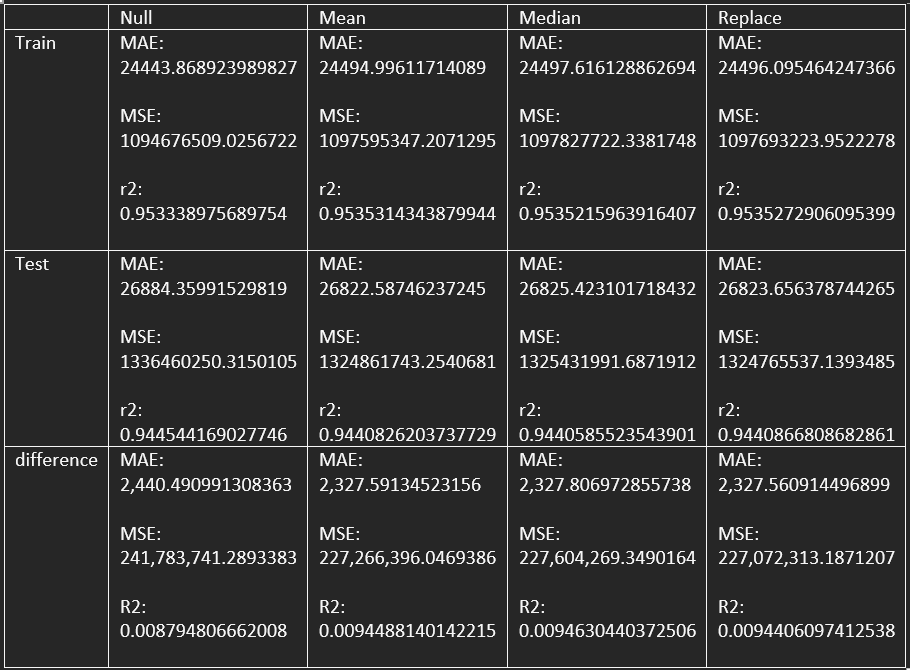

It can be seen that the results are very close.

However, for the train MAE and MSE, null performs the best with it being the only one with a MAE in the 24440 range and MSE in the 1094 million range when the others have the MAE and MSE in the 24490 and 1097 million ranges respectively. This is a difference of roughly 50 and 3 million, for MAE and MSE respectively, and a percentage difference of 0.2% for both

Null performs worse in the train r2 however, as it is the only one with a r2 that is about 0.95333, when the others have an r2 at around 0.95353, this is roughly a difference of 0.00020 and a percentage difference of 0.02%

For the test mae and mse, null performs the worst, with a MAE and MSE at around 26880 and 1336 million respectively, while the other have a mae at roughly 26820 and mse at around 1324.7-1325.4 million. This is a difference of about 60 and 10.95 million, and percentage difference of 0.22% and 0.8%, for MAE and MSE respectively

Null performs the best at r2, however, with the only one having a r2 at about 0.94454, while the rest have a r2 at about 0.94405-0.94408. This is a difference of roughly 0.00047 and a percentage difference of 0.04%

The percentage difference where null's performance is the best is lower than when its performance is the worst. Also, the difference between Train and Test for MAE and MSE for Null is the largest by a big margin among the 4. While the difference for r2 for null is the least, it is only for a small margin, whch does not make up for the mae and mse difference. Therefore, it could be said that null performs the worst.

median also performs poorly as it performs the worst out the group for train results and second worst, only to null, for the test results. the difference between train and test results is also the largest for the entire group, if null is not included.

When comparing mean and replace, mean performs better in the Train MAE, Train MSE, Train R2, and Test MAE. For Test MSE and Test R2, replace performs better and the difference between the Train and Test results for MAE, MSE, and r2 are all lower for replace than mean.

At the instances where mean performs better, for both MAE, it is by a difference of 1.1 and 1.07 for train and test respectively, and 97k for Train MSE and 0.0000042 for Train R2

When replace performs better, for Test MSE, it is a difference of 96k and 0.0000040 for Test R2, both of which is lower than the difference in performance Train MAE and Train R2.

Therefore, although, the difference between the Train and Test results for MAE, MSE, and r2 are all lower for replace than mean, I would still choose mean as the best performing model.

## 6.6 Futher Scaling and final evaluation <a id='6.6'></a>
[Back to top](#top)

After evaluation, I went ahead and scaled the mean results to see if scaling would give better results.

Using Standard scaler, I made a scaler which was then used on the original mean_imputed train and test data to make new scaled versions of them. After fitting the regressor, which did take a while, I was given the results. Besides scaling the previous results, I did not do anything else.

Here are the results

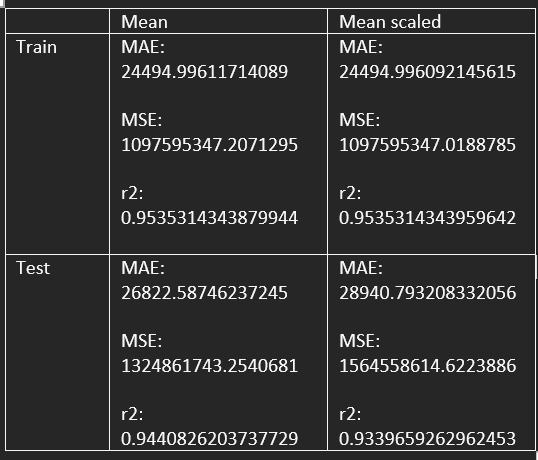

It can be seen that overall and for each MAE, MSE and r2, scaling made the model just a little bit worse.

Therefore, it can be concluded that the best performing model is the one with the missing values imputed as the mean of the column, and it should not be scaled as a scaled model is proven to make the model worse, not improve it.

## 6.7 Summary and Further Improvements <a id='6.7'></a>
[Back to top](#top)

To summarise, it seems that the removal of null values completely does not really benefit the model's performance. Although it did seem that way, somewhat, at first, it actually makes it a bit worse. Maybe because the lesser the amount of data, the more bias it can be?

Also, when imputing the median, it did return the max value instead wo that is one thing to take note of. Maybe it is because that really is the median. If that is the case, then using median for this dataset is not ideal as the median and actual value is probably quite far apart. Maybe that is why the median did quite badly during evaluation.

The replace value and median value are quite similar to each other, actually, that should be why the results are very similar to each other. But it does seem that imputing the mean still did the best.

Also, Scaling causes the model to perform just a little worse, However, even though it is by a miniscule amount, the model still does not perform better. Therefore, it is better to not scale it.

As for further improvements, I would think that value mapping, if it can be done, might make the model abit more accurate. Also, I would like to change the remaining lease to be calculated in years instead of months and the resale amount to be counted in thousands. Maybe that would make the results of the model nicer or slightly more accurate. 

# 7. "Unlisted" Youtube Link to Video Presentation <a id='7'></a>
[Back to top](#top)

In [120]:
# insert your link in this cell, you are allowed to comment it out
# youtube link: https://youtu.be/eNrhR7Q9Q0o